# Project Setup

In [20]:
# Install packages
%pip install numpy
%pip install scipy
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 20.3 MB/s eta 0:00:0000:0100:01
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.


In [33]:
# Imports
import random
import numpy as np
from collections import defaultdict, deque
import scipy.stats as stats
import pandas as pd
from typing import List, Tuple
from matplotlib import pyplot as plt

# Loading Data

In [22]:
# Load data from files
station_probs = {}
with open('data/start_station_probs.csv', 'r') as f:
    next(f)  # Skip header
    for line in f:
        station, prob = line.strip().split(',')
        station_probs[station] = float(prob)

trip_stats = defaultdict(lambda: defaultdict(int))
with open('data/trip_stats.csv', 'r') as f:
    next(f)  # Skip header
    for line in f:
        start, end, count, _, _ = line.strip().split(',')
        trip_stats[start][end] = int(count)

# Initial Simulation

In [23]:
# Simulation parameters
n = 3500
_lambda = 2.38  # Riders per minute
mu = 2.78
sigma = 0.619
logical_day = 1440

In [24]:
# Simulation helper functions
def get_interarrival_time():
    return np.random.exponential(1 / _lambda)

def get_ride_time():
    return np.random.lognormal(mu, sigma)


In [25]:
def run_simulation(num_bikes_per_station):
    stations = defaultdict(int)
    for station in station_probs:
        stations[station] = num_bikes_per_station

    # print(stations)
    waiting_queue = []
    successful_rentals = 0
    arrival_time = 0

    for rider in range(n):
        arrival_time += get_interarrival_time()
        start_station = random.choices(list(station_probs.keys()), weights=list(station_probs.values()), k=1)[0]

        if stations[start_station] > 0:
            stations[start_station] -= 1
            successful_rentals += 1
            end_station = random.choices(list(trip_stats[start_station].keys()),
                                         weights=list(trip_stats[start_station].values()), k=1)[0]
            ride_time = get_ride_time()
            return_time = arrival_time + ride_time
            stations[end_station] += 1
        else:
            waiting_queue.append(arrival_time)

    success_rate = successful_rentals / n
    avg_waiting_time = sum(waiting_queue) / len(waiting_queue) if waiting_queue else 0
    print(len(waiting_queue), waiting_queue)

    return success_rate, avg_waiting_time

In [26]:
# Run simulation
success_rate, avg_waiting_time = run_simulation(num_bikes_per_station=10)


117 [230.90628905575832, 237.6242247504964, 410.69766495257704, 484.9335315566849, 488.61177133276294, 504.83683902329847, 531.1954212143895, 532.1270833353238, 544.5162166117449, 561.2013658433091, 566.6453438070298, 566.9857878877151, 568.536398201382, 578.446063564906, 589.8473435266268, 597.4285568266043, 615.1817174995147, 620.4081792990897, 622.4362131073108, 640.516638651754, 674.9164385125029, 709.5817653097199, 712.3536028252919, 719.212891636899, 721.1297434461067, 750.5643436409399, 754.7431490429752, 755.4917873160703, 758.6168920966967, 775.7482349771354, 799.4615618806461, 807.0909611573315, 809.3456062929024, 818.2017868634268, 819.323427277313, 845.0348510290983, 858.641414861127, 870.0540528109901, 896.5940362080172, 924.3366732246254, 935.5894832616648, 938.7380929088229, 950.8565835125914, 951.0580533272035, 953.005942718152, 961.0439982901821, 964.3196398306419, 964.4892318567311, 965.144927715331, 977.395301506444, 994.6751541622231, 995.3188963533438, 996.57101625

In [27]:
confidence = 0.90
p = success_rate
std_err = np.sqrt(p * (1 - p) / n)
confidence_interval = stats.norm.interval(confidence, loc=p, scale=std_err)

print(f"Probability of a successful rental: {success_rate:.4f}")
print(f"Average waiting time for riders who got a bike: {avg_waiting_time:.4f} minutes")
print(f"90% Confidence Interval for Success Rate: {confidence_interval}")

Probability of a successful rental: 0.9666
Average waiting time for riders who got a bike: 1033.0130 minutes
90% Confidence Interval for Success Rate: (0.9615737408026087, 0.9715691163402483)


# Task 1 - Revised Simulation (Accounting for Arrival/Return Times, Wait Times)
I noticed that the average wait time seemed strange, so I created a simulation with an events list to account for arrival and return times. We were also not accounting for the success rate correctly, as the 24-hour period could occur before 3500 arrivals, so we need to count riders separately within that window for this computation. ~ Ree

In [28]:
ARRIVAL = 'arrival'
RETURN = 'return'
LOGICAL_DAY = 1440

class BikeShareSimulation:
    def __init__(self, num_bikes_per_station: int, n: int, _lambda: float, mu: float, sigma: float, station_probs: dict, trip_stats: defaultdict):
        self.num_bikes_per_station = num_bikes_per_station
        self.n = n
        self._lambda = _lambda
        self.mu = mu
        self.sigma = sigma
        self.station_probs = station_probs
        self.trip_stats = trip_stats

    def _get_interarrival_time(self):
        return np.random.exponential(1 / self._lambda)

    def _get_ride_time(self):
        return np.random.lognormal(self.mu, self.sigma)

    def run(self) -> Tuple[float, float, float]:
        stations = defaultdict(lambda: self.num_bikes_per_station)
        waiting_queues = defaultdict(deque)
        successful_rentals, current_time, rider_count = 0, 0, 0
        ride_times, wait_times, events = [], [], []

        while current_time < logical_day and rider_count < self.n:
            interarrival_time = self._get_interarrival_time()
            current_time += interarrival_time
            if current_time >= logical_day or rider_count >= self.n:
                break
            start_station = random.choices(list(self.station_probs.keys()), weights=list(self.station_probs.values()), k=1)[0]
            rider_count += 1
            events.append((current_time, ARRIVAL, start_station))

        events.sort(key=lambda x: x[0])

        for event in events:
            time, event_type, station = event

            if event_type == ARRIVAL:
                if stations[station] > 0:
                    stations[station] -= 1
                    successful_rentals += 1
                    end_station = random.choices(list(self.trip_stats[station].keys()),
                                                weights=list(self.trip_stats[station].values()), k=1)[0]
                    ride_time = self._get_ride_time()
                    ride_times.append(ride_time)
                    wait_times.append(0)
                    return_time = time + ride_time
                    events.append((return_time, RETURN, end_station))
                    events.sort(key=lambda x: x[0])
                else:
                    waiting_queues[station].append(time)

            elif event_type == RETURN:
                stations[station] += 1
                if waiting_queues[station]:
                    waiting_time = waiting_queues[station].popleft()
                    waiting_duration = time - waiting_time
                    wait_times.append(waiting_duration)
                    stations[station] -= 1
                    successful_rentals += 1 

        success_rate = successful_rentals / rider_count
        avg_waiting_time = sum(wait_times) / len(wait_times) if wait_times else 0
        avg_ride_time = np.mean(ride_times) if ride_times else 0

        return success_rate, avg_waiting_time, avg_ride_time

# Task 2 - Baseline Experiment

In [29]:
simulation = BikeShareSimulation(n=3500, _lambda=2.38, mu=2.78, sigma=0.619, num_bikes_per_station=10, station_probs=station_probs, trip_stats=trip_stats)
success_rate, avg_waiting_time, avg_ride_time = simulation.run()

confidence = 0.90
p = success_rate
std_err = np.sqrt(p * (1 - p) / n)
confidence_interval = stats.norm.interval(confidence, loc=p, scale=std_err)

print(f"Probability of a successful rental: {success_rate:.4f}")
print(f"Average waiting time for riders who got a bike: {avg_waiting_time:.4f} minutes")
print(f"Average ride time for riders who got a bike: {avg_ride_time:.4f} minutes")
print(f"90% Confidence Interval for Success Rate: {confidence_interval}")

Probability of a successful rental: 0.8791
Average waiting time for riders who got a bike: 20.4681 minutes
Average ride time for riders who got a bike: 19.0624 minutes
90% Confidence Interval for Success Rate: (0.8700801254620589, 0.8882055888236553)


# Task 3 - Idealized Experiment 
Simulation to find minimum # of bikes for 100% success

In [41]:
df = pd.DataFrame(columns=['Number of bikes per station', 'Probability of a successful rental', 'Average waiting time', 'Average ride time'])
num_bikes = [i for i in range(1, 101)]
probs, waits, rides = [], [], []

for i in range(1, 101):
    simulation = BikeShareSimulation(n=3500, _lambda=2.38, mu=2.78, sigma=0.619, num_bikes_per_station=i, station_probs=station_probs, trip_stats=trip_stats)
    success_rate, avg_waiting_time, avg_ride_time = simulation.run()

    probs.append(success_rate)
    waits.append(avg_waiting_time)
    rides.append(avg_ride_time)

    print(f"Number of bikes per station: {i}")
    print(f"Probability of a successful rental: {success_rate:.4f}")
    print(f"Average waiting time for riders who got a bike: {avg_waiting_time:.4f} minutes")
    print(f"Average ride time for riders who got a bike: {avg_ride_time:.4f} minutes")

    confidence = 0.90
    p = success_rate
    std_err = np.sqrt(p * (1 - p) / n)
    confidence_interval = stats.norm.interval(confidence, loc=p, scale=std_err)
    print(f"90% Confidence Interval for Success Rate: {confidence_interval}")

    print()

df['Number of bikes per station'] = num_bikes
df['Probability of a successful rental'] = probs
df['Average waiting time'] = waits
df['Average ride time'] = rides

Number of bikes per station: 1
Probability of a successful rental: 0.0703
Average waiting time for riders who got a bike: 26.5170 minutes
Average ride time for riders who got a bike: 19.1316 minutes
90% Confidence Interval for Success Rate: (0.06319091083910458, 0.07740662870395343)

Number of bikes per station: 2
Probability of a successful rental: 0.1556
Average waiting time for riders who got a bike: 29.7046 minutes
Average ride time for riders who got a bike: 18.8634 minutes
90% Confidence Interval for Success Rate: (0.14552959757741527, 0.16568590447778145)

Number of bikes per station: 3
Probability of a successful rental: 0.2457
Average waiting time for riders who got a bike: 40.5147 minutes
Average ride time for riders who got a bike: 18.5411 minutes
90% Confidence Interval for Success Rate: (0.23373167043001852, 0.25767025320740494)

Number of bikes per station: 4
Probability of a successful rental: 0.3404
Average waiting time for riders who got a bike: 50.4643 minutes
Average

/Users/reeteshsudhakar/miniconda3/envs/CX-4230/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/reeteshsudhakar/miniconda3/envs/CX-4230/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Number of bikes per station: 23
Probability of a successful rental: 0.9941
Average waiting time for riders who got a bike: 2.6785 minutes
Average ride time for riders who got a bike: 19.3333 minutes
90% Confidence Interval for Success Rate: (0.9920037523576934, 0.9962522664326765)

Number of bikes per station: 24
Probability of a successful rental: 0.9976
Average waiting time for riders who got a bike: 1.0047 minutes
Average ride time for riders who got a bike: 19.4365 minutes
90% Confidence Interval for Success Rate: (0.9962493890309981, 0.9989659219737866)

Number of bikes per station: 25
Probability of a successful rental: 0.9991
Average waiting time for riders who got a bike: 0.3391 minutes
Average ride time for riders who got a bike: 19.4242 minutes
90% Confidence Interval for Success Rate: (0.9983292146274354, 0.9999564996582788)

Number of bikes per station: 26
Probability of a successful rental: 0.9947
Average waiting time for riders who got a bike: 1.9178 minutes
Average ride 

In [42]:
df

,Number of bikes per station,Probability of a successful rental,Average waiting time,Average ride time
0,1,0.070299,26.517038,19.131642
1,2,0.155608,29.704576,18.863446
2,3,0.245701,40.514698,18.541052
3,4,0.340438,50.464344,19.281995
4,5,0.466389,40.241870,19.375895
...,...,...,...,...
95,96,1.000000,0.000000,19.528675
96,97,1.000000,0.000000,19.544598
97,98,1.000000,0.000000,19.739680
98,99,1.000000,0.000000,19.482838


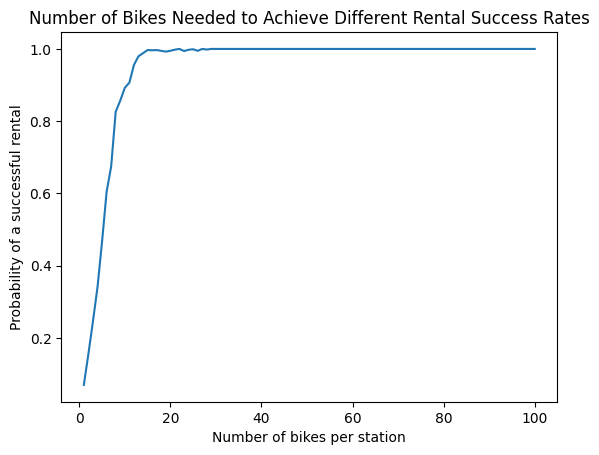

In [43]:
plt.plot(df['Number of bikes per station'], df['Probability of a successful rental'])
plt.xlabel('Number of bikes per station')
plt.ylabel('Probability of a successful rental')
plt.title('Number of Bikes Needed to Achieve Different Rental Success Rates')
plt.show()

In [51]:
data = pd.read_csv('data/raw_trips.csv')
data = data[(data['started_at'] >= '2022-06-01') & (data['started_at'] <= '2022-07-31')]
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,dt
0,89CDCE3224502904,classic_bike,2022-07-21 18:19:45,2022-07-21 18:28:21,Marshall St & 2 St,HB408,8 St & Washington St,HB603,40.740802,-74.042521,40.745984,-74.028199,member,8.600000
1,3E6E50F51BD4CBD9,electric_bike,2022-07-21 17:50:57,2022-07-21 17:59:17,Marshall St & 2 St,HB408,11 St & Washington St,HB502,40.740802,-74.042521,40.749985,-74.027150,casual,8.333333
2,8A9058FAA9115562,electric_bike,2022-07-23 11:51:55,2022-07-23 11:59:16,Marshall St & 2 St,HB408,Oakland Ave,JC022,40.740802,-74.042521,40.737604,-74.052478,member,7.350000
3,C566A187663748AE,classic_bike,2022-07-30 20:34:40,2022-07-30 20:48:40,Marshall St & 2 St,HB408,Bloomfield St & 15 St,HB203,40.740802,-74.042521,40.754530,-74.026580,member,14.000000
4,7E754D57276BE57E,classic_bike,2022-07-14 18:42:34,2022-07-14 18:49:45,Marshall St & 2 St,HB408,Clinton St & 7 St,HB303,40.740802,-74.042521,40.745420,-74.033320,casual,7.183333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405762,25AD34565A260732,classic_bike,2022-06-17 16:03:36,2022-06-17 16:33:48,South Waterfront Walkway - Sinatra Dr & 1 St,HB103,11 St & Washington St,HB502,40.736982,-74.027781,40.749985,-74.027150,casual,30.200000
405763,8A4181FCE9439036,classic_bike,2022-06-25 14:14:26,2022-06-25 14:19:40,South Waterfront Walkway - Sinatra Dr & 1 St,HB103,8 St & Washington St,HB603,40.736982,-74.027781,40.745984,-74.028199,member,5.233333
405764,28C8501BCB596743,electric_bike,2022-06-04 08:57:04,2022-06-04 09:15:33,Jersey & 6th St,JC027,11 St & Washington St,HB502,40.725289,-74.045572,40.749985,-74.027150,casual,18.483333
405765,D28575BBFF3A0B57,classic_bike,2022-06-17 06:11:05,2022-06-17 06:21:37,South Waterfront Walkway - Sinatra Dr & 1 St,HB103,11 St & Washington St,HB502,40.736982,-74.027781,40.749985,-74.027150,member,10.533333


# Task 4 - Checking Assumptions

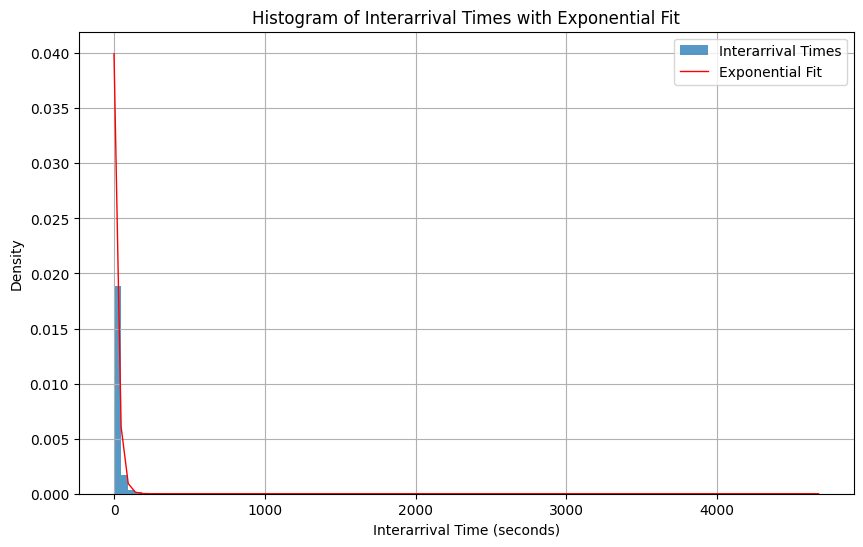

(count    207117.000000
 mean         25.028689
 std          67.762992
 min           0.000000
 25%           5.000000
 50%          12.000000
 75%          26.000000
 max        4673.000000
 Name: started_at, dtype: float64,
 0.0,
 25.028689098432288)

In [55]:
from scipy.stats import expon

# Convert 'started_at' to datetime
data['started_at'] = pd.to_datetime(data['started_at'])

data_sorted = data.sort_values('started_at')

interarrival_times = data_sorted['started_at'].diff().dt.total_seconds().dropna()
interarrival_stats = interarrival_times.describe()

loc, scale = expon.fit(interarrival_times, floc=0) 

plt.figure(figsize=(10, 6))
plt.hist(interarrival_times, bins=100, density=True, alpha=0.75, label='Interarrival Times')
x = np.linspace(interarrival_times.min(), interarrival_times.max(), 100)
plt.plot(x, expon.pdf(x, loc, scale), 'r-', lw=1, label='Exponential Fit')

plt.title('Histogram of Interarrival Times with Exponential Fit')
plt.xlabel('Interarrival Time (seconds)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

interarrival_stats, loc, scale

# Notes for Analysis of Interarrival Times
- Descriptive statistics of the analysis are above
- **Re:** Exponential Distribution: we can see some adherence to an exponential model, especially for smaller interarrival times, but the distribution has a long tail
- **Re:** Stationarity and Independence: wide range and high standard deviation compared to the mean might suggest that the interarrival times are influenced by factors that change over time